

In this lab, you will learn how to build **very deep convolutional neural networks** using **Residual Networks (ResNets)**. While deeper networks can theoretically learn highly complex functions, they are often difficult to train in practice due to challenges such as the **vanishing gradient problem**.  

**Residual Networks**, introduced by [He et al. (2015)](https://arxiv.org/pdf/1512.03385.pdf), solved this issue and made it possible to train extremely deep models efficiently.

ResNet was the breakthrough architecture that won the **2015 ImageNet Large Scale Visual Recognition Challenge (ILSVRC)** and has influenced almost every deep learning model since then. Residual connections are now used in:

- Recurrent models ([Kim et al., 2017](https://arxiv.org/abs/1701.03360), [Prakash et al., 2016](https://arxiv.org/abs/1610.03098))
- Transformers ([Vaswani et al., 2017](https://arxiv.org/abs/1706.03762))
- Graph neural networks ([Kipf & Welling, 2016](https://arxiv.org/abs/1609.02907))

Today, residual ideas form the backbone of modern deep learning architectures.


## Learning Objectives

**In this notebook, you will:**

- Understand and implement the core building blocks of **ResNets**
- Combine these blocks to construct a **50-layer network**
- Train this deep network for **image classification**
- Load and fine-tune a **pre-trained ResNet-50** model in Keras
- Run training on a **GPU** for the first time (deep network ≈ 50 layers!)

We will use **Keras with PyTorch as the backend** for this lab.



###  Before You Begin

Run the cell below to import the required packages.

If your laptop has a GPU (e.g., Apple Silicon MacBook or a gaming laptop), the code will automatically use it. Otherwise, it will run on CPU.  

> 💡 **Tip:** Try running this notebook on both CPU and GPU (e.g., using Google Colab) to experience how significantly a GPU accelerates model training.

Let's get started 👇


In [91]:
import os
os.environ['KERAS_BACKEND']='torch'

In [92]:
import keras
import torch

import keras.backend as K
K.set_image_data_format('channels_last')

In [93]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    device_name = torch.cuda.get_device_name(0)
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    device_name = "Apple Silicon MPS (Metal Performance Shaders)"
else:
    device = torch.device("cpu")
    device_name = "CPU"

print(f"Training on: {device_name}")

Training on: Apple Silicon MPS (Metal Performance Shaders)


In [94]:

device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
print(f"Using device: {device}")
# print keras backend

print(f"Keras backend: {keras.backend.backend()}")
print(f"Torch version: {torch.__version__}")
print(f"Keras version: {keras.__version__}")

Using device: mps
Keras backend: torch
Torch version: 2.8.0
Keras version: 3.11.3


## 1 - The Problem of Very Deep Neural Networks

Modern neural networks have grown dramatically in depth — from a few layers (e.g., AlexNet) to hundreds in today’s architectures. Deeper models can represent more complex functions and learn hierarchical features, from simple edges in early layers to abstract concepts in deeper layers.

However, simply stacking more layers does **not** always improve performance. A major challenge is the **vanishing gradient problem**.


###  Vanishing Gradients

During backpropagation, gradients flow from the final layer back to earlier layers. At each step, gradients are multiplied by weight matrices (and activation derivatives). In very deep networks, this can cause gradients to:

-  **Shrink exponentially** → approach zero (**vanishing gradients**)  
-  **Grow exponentially** → explode to large values (**exploding gradients**, less common)

Even with:

- ✅ Proper weight initialization  
- ✅ ReLU activations  
- ✅ Batch normalization  

**Training very deep networks is still harder** because gradients struggle to flow backward through many layers.  
Result: **Early layers learn slowly or stop learning** → inefficient training and poor performance.


###  What You Observe During Training

Gradient norms for earlier layers typically decrease rapidly:

> **Earlier layers receive very weak learning signal → slow or stalled learning**

*(See figure below — earlier layers' gradients decay faster)*

<img src="images/vanishing_grad_kiank.png" style="width:450px;height:220px;">
<caption><center> <u> <font color='purple'> <b>Figure 1</b> </u><font color='purple'>  : <b>Vanishing gradient</b> <br> The speed of learning decreases very rapidly for the early layers as the network trains </center></caption>

**Key takeaway:**  
> Gradient flow weakens as networks deepen, making optimization difficult without special architectural mechanisms.



###  What's Next?

To address this, modern architectures introduce **skip (residual) connections**, which allow gradients to bypass layers and flow more easily.

You will now build a **Residual Network (ResNet)** to overcome the vanishing gradient problem.


## 2 - Building a Residual Network

### 2.0 - The Core Idea: Skip Connections

In ResNets, a **"shortcut"** or **"skip connection"** allows information and gradients to flow directly to earlier layers, bypassing intermediate transformations:  

<img src="images/skip_connection_kiank.png" style="width:650px;height:200px;">
<caption><center> <u> <font color='purple'> <b>Figure 2</b> </u><font color='purple'>  : A ResNet block showing a <b>skip-connection</b> <br> </center></caption>

**Left**: Traditional "main path" — input passes through multiple transformations sequentially.  
**Right**: ResNet block — the shortcut connection enables the network to learn **residual mappings**.



### 2.1 Key Innovation: Learning Residuals Instead of Direct Mappings

**Traditional approach**: Learn a direct mapping $H(x)$ from input $x$.

**ResNet approach**: Learn a residual function $F(x)$ such that:

$$H(x) = F(x) + x$$

where:

- $x$ is the input (identity/shortcut)
- $F(x)$ is the residual learned by the stacked layers
- $H(x)$ is the final output

**Why is this easier to optimize?**

1. **If optimal mapping is close to identity** ($H(x) \approx x$), it's easier to learn $F(x) \approx 0$ than to learn $H(x) = x$ directly
2. **Gradient flow**: During backpropagation, gradients can flow through both:
   - The main path: $\frac{\partial F(x)}{\partial x}$
   - The shortcut: $\frac{\partial x}{\partial x} = 1$ (direct path with gradient = 1)

This ensures at least some gradient always reaches earlier layers!

**Benefits of Residual Learning**

| Traditional Deep Networks | Residual Networks (ResNets) |
|---------------------------|----------------------------|
| Gradients vanish exponentially | Skip connections provide gradient highway |
| Harder to optimize as depth increases | Easy to optimize even with 100+ layers |
| Adding layers can hurt performance | Adding layers rarely hurts (can learn identity) |
| Requires careful initialization | More robust to initialization |

### 2.2 Two Types of ResNet Blocks

By stacking these ResNet blocks on top of each other, you can form very deep networks. The architecture uses two main block types based on whether input/output dimensions match:

1. **Identity Block** — When input and output dimensions are the **same**
2. **Convolutional Block** — When dimensions **differ** (e.g., spatial downsampling or channel expansion)


You will now implement both types of ResNet blocks and build a complete ResNet-50 architecture!

#### 2.2.1 - The Identity Block

The **identity block** is the standard building block used in ResNets. It's used when the **input and output dimensions are the same** (i.e., $a^{[l]}$ and $a^{[l+2]}$ have identical shapes).

##### Basic Structure (2-layer skip)

<img src="images/idblock2_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> <b>Figure 3</b> </u><font color='purple'>  : <b>Identity block.</b> Skip connection "skips over" 2 layers. </center></caption>

**Key components:**

- **Upper path (shortcut)**: Direct connection — input passes through unchanged
- **Lower path (main path)**: Sequence of transformations (CONV2D → BatchNorm → ReLU)
- **Final step**: Add both paths and apply ReLU activation


##### Enhanced 3-Layer Identity Block (What You'll Implement)

For better feature extraction, we'll implement a more powerful version where the skip connection jumps over **3 layers**:

<img src="images/idblock3_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> <b>Figure 4</b> </u><font color='purple'>  : <b>Identity block.</b> Skip connection "skips over" 3 layers.</center></caption>


##### Architecture Details

The main path consists of three convolutional components with a **bottleneck design**:

**First Component** (Dimensionality Reduction):

- **CONV2D**: $F_1$ filters, kernel size (1,1), stride (1,1), padding='valid'
  - *Purpose*: Reduce channel dimensions (bottleneck)
  - *Name*: `conv_name_base + '2a'`
- **BatchNorm**: Normalize channels axis → `bn_name_base + '2a'`
- **Activation**: ReLU

**Second Component** (Feature Extraction):

- **CONV2D**: $F_2$ filters, kernel size $(f,f)$, stride (1,1), padding='same'
  - *Purpose*: Extract spatial features at reduced dimensionality
  - *Name*: `conv_name_base + '2b'`
- **BatchNorm**: Normalize channels axis → `bn_name_base + '2b'`
- **Activation**: ReLU

**Third Component** (Dimensionality Expansion):

- **CONV2D**: $F_3$ filters, kernel size (1,1), stride (1,1), padding='valid'
  - *Purpose*: Restore original channel dimensions
  - *Name*: `conv_name_base + '2c'`
- **BatchNorm**: Normalize channels axis → `bn_name_base + '2c'`
- **No ReLU** (activation applied after adding shortcut)

**Final Step**:

- **Add**: Shortcut + Main path output
- **Activation**: ReLU on combined result


##### Why This Bottleneck Design?

The **1×1 → 3×3 → 1×1** pattern is called a **bottleneck architecture**:

```
Input channels: 256
    ↓
1×1 conv: 256 → 64   (reduce dimensions - fewer parameters!)
    ↓
3×3 conv: 64 → 64    (extract features at lower cost)
    ↓
1×1 conv: 64 → 256   (restore dimensions)
    ↓
Add shortcut: 256 + 256 → 256
```

**Benefits**:

- ✅ **Fewer parameters**: 3×3 conv operates on fewer channels (64 vs 256)
- ✅ **Faster computation**: Reduces computational cost significantly
- ✅ **More depth**: Can stack more layers with same parameter budget
- ✅ **Better features**: Multiple non-linearities capture complex patterns


### Task 1: Implement the ResNet Identity Block

We've implemented the first component for you. 

**Your task**: Complete the second component, third component, and final addition step.

**Implementation hints:**

- Conv2D: [Documentation](https://keras.io/api/layers/convolution_layers/convolution2d/)
- BatchNorm: [Documentation](https://faroit.github.io/keras-docs/1.2.2/layers/normalization/)
  - Set `axis=3` to normalize the channels axis
- Activation: Use `Activation('relu')(X)`
- Add layers: [Documentation](https://keras.io/api/layers/merging_layers/add/)

In [95]:
from keras.layers import Conv2D, BatchNormalization, Activation, Add

# FUNCTION: identity_block

def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network

    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. You'll need this later to add back to the main path.
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a' )(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b' )(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c' )(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    ### END CODE HERE ###

    return X

In [96]:

import numpy as np
np.random.seed(1)
X = np.random.randn(3, 4, 4, 6)
output = identity_block(X, f = 2, filters = [2, 4, 6], stage = 1, block = 'a')

print(output.cpu().detach().numpy().sum())


116.51095


**Expected Output**:

<table>
    <tr>
        <td>
           A value between <b>100</b> and <b>140</b>
        </td>
    </tr>
</table>

#### 2.2 - The Convolutional Block

You've mastered the identity block! Now let's tackle the **convolutional block** — the second essential building block in ResNet.

##### When to Use Convolutional Blocks

Use this block when **input and output dimensions DON'T match**, such as:

-  **Spatial downsampling**: Reducing height/width (e.g., 32×32 → 16×16)
-  **Channel expansion**: Increasing depth (e.g., 128 channels → 256 channels)
-  **Transitioning between stages** in the network


##### Key Difference: Shortcut Path Has a Convolution

<img src="images/convblock_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> <b>Figure 5</b> </u><font color='purple'>  : <b>Convolutional block</b> </center></caption>

**Unlike the identity block**, the shortcut path contains:

- **CONV2D layer**: Transforms input to match output dimensions
- **BatchNorm**: Normalizes the transformed shortcut
- **No activation**: Shortcut applies only a linear transformation

**Why is this needed?**

For the final addition to work, both paths must have **matching dimensions**:
```python
# This MUST work:
output = main_path_output + shortcut_output  # Shapes must match!
```

If input is `(32, 32, 128)` and output should be `(16, 16, 256)`:
- Main path reduces spatial dimensions and expands channels
- Shortcut path ALSO must transform `(32, 32, 128)` → `(16, 16, 256)`



#####  Architecture Details

**Main Path** (same as identity block, but with stride):

**First Component**:

- **CONV2D**: $F_1$ filters, (1,1), **stride (s,s)**, padding='valid'
  -  **Stride s**: This is where spatial downsampling happens!
  - *Name*: `conv_name_base + '2a'`
- **BatchNorm**: `bn_name_base + '2a'`
- **Activation**: ReLU

**Second Component**:

- **CONV2D**: $F_2$ filters, (f,f), stride (1,1), padding='same'
  - *Name*: `conv_name_base + '2b'`
- **BatchNorm**: `bn_name_base + '2b'`
- **Activation**: ReLU

**Third Component**:

- **CONV2D**: $F_3$ filters, (1,1), stride (1,1), padding='valid'
  - *Name*: `conv_name_base + '2c'`
- **BatchNorm**: `bn_name_base + '2c'`
- **No activation** here



**Shortcut Path** (NEW! This is what makes it different):

- **CONV2D**: $F_3$ filters, (1,1), **stride (s,s)**, padding='valid'
  -  **Same stride as first component** → matches spatial dimensions
  -  **Same number of filters as third component** → matches channels
  - *Name*: `conv_name_base + '1'`
- **BatchNorm**: `bn_name_base + '1'`
- **No activation** (keeps it as a linear projection)



**Final Step**:

- **Add**: Main path + Shortcut path
- **Activation**: ReLU on sum



#####  Dimension Transformation Example

Let's trace dimensions through a convolutional block:

**Input**: `(H, W, C_in)` = `(32, 32, 128)`  
**Parameters**: `s=2`, `filters=[64, 64, 256]`

**Main Path**:
```
Input:          (32, 32, 128)
↓ Conv 1×1, s=2, 64 filters
                (16, 16, 64)   ← stride 2 reduces spatial dims
↓ Conv 3×3, s=1, 64 filters
                (16, 16, 64)   ← same padding preserves dims
↓ Conv 1×1, s=1, 256 filters
Main output:    (16, 16, 256)  ← expand to final channels
```

**Shortcut Path**:
```
Input:          (32, 32, 128)
↓ Conv 1×1, s=2, 256 filters
Shortcut:       (16, 16, 256)  ← matches main path!
```

**Addition**: `(16, 16, 256)` + `(16, 16, 256)` = `(16, 16, 256)` ✅



#####  Why No Activation on Shortcut?

The shortcut represents the **identity (or linear projection) of the input**. Adding a non-linearity would:

- ❌ Break the gradient highway property
- ❌ Make it harder to learn identity mappings
- ❌ Reduce the effectiveness of skip connections

The shortcut should be a **pure information pathway**, while the main path learns non-linear transformations.



### Task 2: Implement the Convolutional Block

We've implemented the first component of the main path. 

**Your task**: Complete the rest.

**What to implement**:

1. Second and third components of main path
2. **Entire shortcut path** (this is the new part!)
3. Final addition and activation

**Key reminders**:

- Use stride `(s,s)` in the FIRST main path conv AND the shortcut conv
- Shortcut has $F_3$ filters (same as third component output)
- No ReLU on shortcut path or after third component (only after final addition)

**References**:

- [Conv2D](https://keras.io/layers/convolutional/#conv2d)
- [BatchNorm](https://keras.io/layers/normalization/#batchnormalization) (use `axis=3`)
- [Activation](https://keras.io/layers/core/#activation): `Activation('relu')(X)`
- [Add](https://keras.io/layers/merge/#add)

In [97]:
from keras.layers import Conv2D, BatchNormalization, Activation, Add

def convolutional_block(X, f, filters, stage, block, s=2):
    """
    Implementation of the convolutional block as defined in Figure 4.
    """

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters
    X_shortcut = X

    ##### MAIN PATH #####
    # First component
    X = Conv2D(F1, (1, 1), strides=(s, s), name=conv_name_base + '2a')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component
    X = Conv2D(F2, (f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component
    X = Conv2D(F3, (1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c')(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #####
    X_shortcut = Conv2D(F3, (1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1')(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    ##### FINAL STEP #####
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


In [98]:
import numpy as np
np.random.seed(1)
X = np.random.randn(3, 4, 4, 6)
output = convolutional_block(X, f = 2, filters = [2, 4, 6], stage = 1, block = 'a')

print(output.detach().cpu().numpy().sum())


34.273724


**Expected Output**:

<table>
    <tr>
        <td>
           20~30
        </td>
    </tr>

</table>



#### Identity Block vs Convolutional Block — Quick Reference

| Feature | Identity Block | Convolutional Block |
|---------|----------------|---------------------|
| **Use Case** | Same input/output dimensions | Different input/output dimensions |
| **Shortcut Path** | Direct connection (no layers) | Conv2D + BatchNorm |
| **Main Path Stride** | Always (1,1) | First conv uses stride (s,s) |
| **When Used** | Within a stage | Between stages (transitions) |
| **Purpose** | Deepen network without changing dims | Spatial downsampling or channel expansion |
| **Example** | Stage 2, blocks 'b' and 'c' | Stage 2, block 'a' (entry to stage) |


### Summary: Building Blocks Mastered!

You've now implemented the two fundamental ResNet building blocks:

```
┌─────────────────────────────────────────────────────────────┐
│                    IDENTITY BLOCK                           │
│  Input (H, W, C) ──────────────────────────┐               │
│       │                                     │               │
│       ├─→ Conv 1×1 (reduce) ─→ BN ─→ ReLU  │               │
│       ├─→ Conv 3×3 (extract) ─→ BN ─→ ReLU  │               │
│       └─→ Conv 1×1 (expand) ─→ BN ─────────┤               │
│                                             ↓               │
│                                         ADD + ReLU          │
│                                             ↓               │
│                                    Output (H, W, C)         │
└─────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────┐
│                 CONVOLUTIONAL BLOCK                         │
│  Input (H, W, C₁) ─────────────────────────┐               │
│       │                                     │               │
│       ├─→ Conv 1×1 (s=2, reduce) ─→ BN ─→ ReLU             │
│       ├─→ Conv 3×3 (s=1, extract) ─→ BN ─→ ReLU             │
│       └─→ Conv 1×1 (s=1, expand) ─→ BN ────┤               │
│                                             │               │
│                                             │               │
│                          Conv 1×1 (s=2) ─→ BN               │
│                                             ↓               │
│                                         ADD + ReLU          │
│                                             ↓               │
│                                  Output (H/2, W/2, C₂)      │
└─────────────────────────────────────────────────────────────┘
```

**Next step**: Stack these blocks to build a complete ResNet-50!

###  Optional: Visualize Block Dimensions

Run the cell below to see how dimensions flow through each block type:

In [99]:
"""
Optional: Visualize how dimensions transform through ResNet blocks
This helps understand the architecture better!
"""
def visualize_block_dimensions():
    print("=" * 70)
    print("IDENTITY BLOCK - Dimension Flow")
    print("=" * 70)

    # Test identity block
    test_input = np.random.randn(1, 16, 16, 256).astype("float32")
    print(f"Input shape:        {test_input.shape}")

    output = identity_block(test_input, f=3, filters=[64, 64, 256], stage=1, block='test')

    if isinstance(output, torch.Tensor):
        output_shape = tuple(output.shape)
    else:
        try:
            from keras import ops as Kops
            output_shape = tuple(Kops.shape(output))
        except:
            output_shape = output.shape

    print(f"Output shape:       {output_shape}")
    print(f"✓ Dimensions preserved (identity block characteristic)")

    print("\n" + "=" * 70)
    print("CONVOLUTIONAL BLOCK - Dimension Flow")
    print("=" * 70)

    # Test convolutional block
    test_input2 = np.random.randn(1, 32, 32, 128).astype("float32")
    print(f"Input shape:        {test_input2.shape}")

    output2 = convolutional_block(test_input2, f=3, filters=[64, 64, 256], stage=2, block='test', s=2)

    if isinstance(output2, torch.Tensor):
        output2_shape = tuple(output2.shape)
    else:
        try:
            from keras import ops as Kops
            output2_shape = tuple(Kops.shape(output2))
        except:
            output2_shape = output2.shape

    print(f"Output shape:       {output2_shape}")
    print(f"✓ Spatial dims reduced by stride 2: {test_input2.shape[1]} → {output2_shape[1]}")
    print(f"✓ Channels expanded: {test_input2.shape[3]} → {output2_shape[3]}")
    print("=" * 70)

#  run visualization
visualize_block_dimensions()

IDENTITY BLOCK - Dimension Flow
Input shape:        (1, 16, 16, 256)
Output shape:       (1, 16, 16, 256)
✓ Dimensions preserved (identity block characteristic)

CONVOLUTIONAL BLOCK - Dimension Flow
Input shape:        (1, 32, 32, 128)
Output shape:       (1, 16, 16, 256)
✓ Spatial dims reduced by stride 2: 32 → 16
✓ Channels expanded: 128 → 256


## 3 - Building your first ResNet model (50 layers)

You now have the necessary blocks to build a very deep ResNet. The following figure describes in detail the architecture of this neural network. "ID BLOCK" in the diagram stands for "Identity block," and "ID BLOCK x3" means you should stack 3 identity blocks together.

<img src="images/resnet_kiank.png" style="width:850px;height:150px;">
<caption><center> <u> <font color='purple'> <b>Figure 5 </b></u><font color='purple'>  : <b>ResNet-50 model</b> </center></caption>

The details of this ResNet-50 model are:

- Zero-padding pads the input with a pad of (3,3)
- Stage 1:
    - The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2). Its name is "conv1".
    - BatchNorm is applied to the channels axis of the input.
    - MaxPooling uses a (3,3) window and a (2,2) stride.
- Stage 2:
    - The convolutional block uses three set of filters of size [64,64,256], "f" is 3, "s" is 1 and the block is "a".
    - The 2 identity blocks use three set of filters of size [64,64,256], "f" is 3 and the blocks are "b" and "c".
- Stage 3:
    - The convolutional block uses three set of filters of size [128,128,512], "f" is 3, "s" is 2 and the block is "a".
    - The 3 identity blocks use three set of filters of size [128,128,512], "f" is 3 and the blocks are "b", "c" and "d".
- Stage 4:
    - The convolutional block uses three set of filters of size [256, 256, 1024], "f" is 3, "s" is 2 and the block is "a".
    - The 5 identity blocks use three set of filters of size [256, 256, 1024], "f" is 3 and the blocks are "b", "c", "d", "e" and "f".
- Stage 5:
    - The convolutional block uses three set of filters of size [512, 512, 2048], "f" is 3, "s" is 2 and the block is "a".
    - The 2 identity blocks use three set of filters of size [512, 512, 2048], "f" is 3 and the blocks are "b" and "c".
- The 2D Average Pooling uses a window of shape (2,2) and its name is "avg_pool".
- The flatten doesn't have any hyperparameters or name.
- The Fully connected layer reduces its input to the number of classes using a softmax activation. Its name should be `'fc' + str(classes)`.

### Task 3: Implement the ResNet with 50 layers described in the figure above.
We have implemented Stages 1 and 2. Please implement the rest. (The syntax for implementing Stages 3-5 should be quite similar to that of Stage 2.) Make sure you follow the naming convention in the text above.

You'll need to use this function:

- Average pooling [see reference](https://keras.io/layers/pooling/#averagepooling2d)

Here're some other functions we used in the code below:

- Conv2D: [See reference](https://keras.io/layers/convolutional/#conv2d)
- BatchNorm: [See reference](https://keras.io/layers/normalization/#batchnormalization) (axis: Integer, the axis that should be normalized (typically the features axis))
- Zero padding: [See reference](https://keras.io/layers/convolutional/#zeropadding2d)
- Max pooling: [See reference](https://keras.io/layers/pooling/#maxpooling2d)
- Fully connected layer: [See reference](https://keras.io/layers/core/#dense)
- Addition: [See reference](https://keras.io/layers/merge/#add)

In [100]:
# FUNCTION: ResNet50

from keras.layers import Input, ZeroPadding2D, AveragePooling2D, Flatten, Dense, Conv2D, MaxPooling2D
from keras.models import Model

def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)


    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1')(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f=3, filters=[256,256,1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256,256,1024], stage=4, block='b')
    X = identity_block(X, 3, [256,256,1024], stage=4, block='c')
    X = identity_block(X, 3, [256,256,1024], stage=4, block='d')
    X = identity_block(X, 3, [256,256,1024], stage=4, block='e')
    X = identity_block(X, 3, [256,256,1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f=3, filters=[512,512,2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512,512,2048], stage=5, block='b')
    X = identity_block(X, 3, [512,512,2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size=(2, 2), name="avg_pool")(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes))(X)


    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

Run the following code to build the model's graph. 

In [101]:
model = ResNet50(input_shape = (64, 64, 3), classes = 6)

In [102]:
# print model summary
model.summary()

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 70, 70, 3) │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 32, 32,    │      9,472 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_conv1            │ (None, 32, 32,    │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_137      │ (None, 32, 32,    │          0 │ bn_conv1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 15, 15,    │          0 │ activation_137[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2a_branch2a      │ (None, 15, 15,    │      4,160 │ max_pooling2d_2[… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2a_branch2a       │ (None, 15, 15,    │        256 │ res2a_branch2a[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_138      │ (None, 15, 15,    │          0 │ bn2a_branch2a[0]… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2a_branch2b      │ (None, 15, 15,    │     36,928 │ activation_138[0… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2a_branch2b       │ (None, 15, 15,    │        256 │ res2a_branch2b[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_139      │ (None, 15, 15,    │          0 │ bn2a_branch2b[0]… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2a_branch2c      │ (None, 15, 15,    │     16,640 │ activation_139[0… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2a_branch1       │ (None, 15, 15,    │     16,640 │ max_pooling2d_2[… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2a_branch2c       │ (None, 15, 15,    │      1,024 │ res2a_branch2c[0… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2a_branch1        │ (None, 15, 15,    │      1,024 │ res2a_branch1[0]… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_45 (Add)        │ (None, 15, 15,    │          0 │ bn2a_branch2c[0]

 Total params: 23,600,006 (90.03 MB)

 Trainable params: 23,546,886 (89.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

### Compile the Model 

Run the following code to compile your model

   - `accuracy` as the evaluation metric

In [103]:

print("\nCompiling model...")

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("\nFinished Compiling model...")


Compiling model...

Finished Compiling model...


The model is now ready to be trained. The only thing you need is a dataset.

## 4 - Applying the ResNet model (50 layers) to the sign dataset

Let's load the SIGNS Dataset.

<img src="images/signs_data_kiank.png" style="width:450px;height:250px;">
<caption><center> <u> <font color='purple'> <b>Figure 6</b> </u><font color='purple'>  : <b>SIGNS dataset</b> </center></caption>

> **Note:**  
> In this dataset, the labels are **one-hot encoded**, so we compile the model with:
>
> ```python
> loss='categorical_crossentropy'
> ```
>
> If your labels are instead **integer class indices** (e.g., `0, 1, 2, ...`), then you should use:
>
> ```python
> loss='sparse_categorical_crossentropy'
> ```
>
> Both losses compute the same objective — they simply expect labels in different formats.


In [104]:
import h5py
import math

def load_dataset():
    # Loading the training and test datasets, you may need to change the path to where you have saved these files
    train_dataset = h5py.File('train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes



def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [105]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()
print(X_train_orig.shape, Y_train_orig.shape, X_test_orig.shape, Y_test_orig.shape, classes.shape)
# shuffle the training dataset
np.random.seed(1)
m = X_train_orig.shape[0]
permutation = list(np.random.permutation(m))
X_train_orig = X_train_orig[permutation]
Y_train_orig = Y_train_orig[:, permutation]

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

val_size = int(len(X_train)*0.8)
X_val = X_train[val_size:]
Y_val = Y_train[val_size:]
X_train = X_train[:val_size]
Y_train = Y_train[:val_size]


print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_val shape: " + str(X_val.shape))
print ("Y_val shape: " + str(Y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

(1080, 64, 64, 3) (1, 1080) (120, 64, 64, 3) (1, 120) (6,)
number of training examples = 864
number of test examples = 120
X_train shape: (864, 64, 64, 3)
Y_train shape: (864, 6)
X_val shape: (216, 64, 64, 3)
Y_val shape: (216, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


### Train Your Model for 2 Epochs

To begin, train the model for just **2 epochs**.  
This short run helps ensure that everything is working correctly and that your device (CPU or GPU) can train the model without any issues.

In [106]:
# Train for 2 epochs
model.fit(X_train, Y_train, epochs = 2, batch_size = 32)

Epoch 1/2
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 447ms/step - accuracy: 0.3264 - loss: 2.8002
Epoch 2/2
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 445ms/step - accuracy: 0.6285 - loss: 1.4900


**Expected Output**:

<table>
    <tr>
        <td>
            <b> Epoch 1/2 </b>
        </td>
        <td>
           loss: between 1 and 5, acc: between 0.2 and 0.5, although your results can be different from ours.
        </td>
    </tr>
    <tr>
        <td>
            <b> Epoch 2/2 </b>
        </td>
        <td>
           loss: between 1 and 5, acc: between 0.3 and 0.7, you should see your loss decreasing and the accuracy increasing.
        </td>
    </tr>

</table>

### Task 5: Output the test accuracy of this model (trained on only two epochs)


In [107]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.1667 - loss: 4.5483
Loss = 4.548338890075684
Test Accuracy = 0.1666666716337204


**Expected Output**:

<table>
    <tr>
        <td>
            <b>Test Accuracy</b>
        </td>
        <td>
           between 0.16 and 0.25
        </td>
    </tr>

</table>

For two epochs, You can see that it achieves poor performances. Let's next train it for 50 epochs and see whether the performance will get a lot better.

To prevent overfitting, we use the `EarlyStopping` callback. Training will stop if the validation loss does not improve for several epochs, and the best weights will be restored.

### Train the model for 50 epochs and output the test accuracy

In [108]:
# Adding a Callback for Early Stopping to prevent overfitting
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, start_from_epoch=10,
                           restore_best_weights=True)

In [109]:
# Train a fresh model for 18 epochs with validation split
import time
start_time = time.time()
history_model = model.fit(X_train, Y_train, epochs = 50, batch_size = 32, validation_data=(X_val, Y_val),callbacks =[early_stop])
end_time = time.time()

# Calculate elapsed time
elapsed = end_time - start_time
mins = int(elapsed // 60)
secs = elapsed % 60

print(f"Total training time: {mins} min {secs:.1f} sec")


Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 474ms/step - accuracy: 0.7002 - loss: 0.9105 - val_accuracy: 0.1435 - val_loss: 5.6540
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 474ms/step - accuracy: 0.8993 - loss: 0.2997 - val_accuracy: 0.1481 - val_loss: 2.8459
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 473ms/step - accuracy: 0.9491 - loss: 0.1525 - val_accuracy: 0.1713 - val_loss: 2.3394
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 472ms/step - accuracy: 0.9352 - loss: 0.2054 - val_accuracy: 0.1481 - val_loss: 3.5357
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 475ms/step - accuracy: 0.9722 - loss: 0.1393 - val_accuracy: 0.1759 - val_loss: 2.5100
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 476ms/step - accuracy: 0.8576 - loss: 0.5413 - val_accuracy: 0.2130 - val_loss: 1.9189
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 478ms/step - accuracy: 0.8808 - loss: 0.5037 - val_accuracy: 0.1667 - val_loss: 7.8307
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 481ms/step - accuracy: 0.8056 - loss: 1.0643 - val_accu

### Task 4: Draw the training curve and find the best epoch (lowest validation loss)

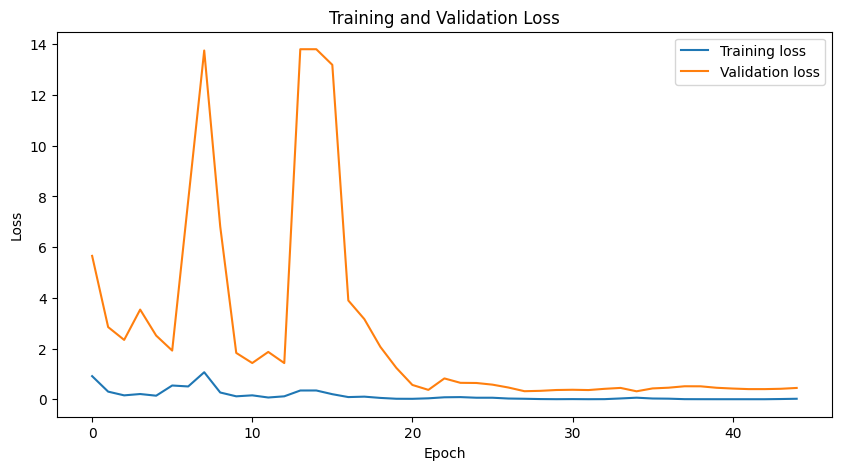

In [110]:
import matplotlib.pyplot as plt
# Plot training & validation loss
plt.figure(figsize=(10,5))
plt.plot(history_model.history['loss'], label='Training loss')
plt.plot(history_model.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [111]:
import numpy as np

best_epoch = np.argmin(history_model.history['val_loss']) + 1  # +1 because epochs start at 1
best_val_loss = np.min(history_model.history['val_loss'])

print(f"Best epoch: {best_epoch}")
print(f"Lowest validation loss: {best_val_loss:.4f}")


Best epoch: 35
Lowest validation loss: 0.3128


### Task 5: output the test accuracy

In [112]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9375 - loss: 0.1954

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8583 - loss: 0.4072
Test loss: 0.4072
Test accuracy: 0.8583


## 5 - `ResNet50` in Keras
ResNet50 is a powerful convolutional neural network architecture commonly used for image classification tasks. Keras offers the [ResNet50 model](https://keras.io/api/applications/) pre-trained on the ImageNet dataset, facilitating rapid development and achieving high accuracy on various image recognition tasks.

In the next step, we will leverage this pre-trained ResNet50 model to compare its performance with our custom implementation. This comparative analysis will provide insights into the effectiveness and efficiency of both approaches for image classification.


In [113]:
from keras.applications import ResNet50

# Load the ResNet50 model without the top classification layer
base_model = ResNet50(weights=None, include_top=False, input_shape=(64, 64, 3))

X = base_model.output
X = AveragePooling2D(pool_size=(2, 2), name = 'avg_pool')(X)
X = Flatten()(X)

# Add a softmax layer for the number of classes (6 in this case)
predictions = Dense(6, activation='softmax')(X)

# Create the final model
ResNet50_keras_model = Model(inputs=base_model.input, outputs=predictions)


### Task 6: Using the same model configuration you implemented above, train the model and report the test accuracy below.

In [115]:
# Adding a Callback for Early Stopping to prevent overfitting
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, start_from_epoch=10,
                           restore_best_weights=True)

# Train a fresh model for 18 epochs with validation split
import time
start_time = time.time()
ResNet50_keras_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_model = ResNet50_keras_model.fit(X_train, Y_train, epochs = 50, batch_size = 32, validation_data=(X_val, Y_val),callbacks =[early_stop])
end_time = time.time()

# Calculate elapsed time
elapsed = end_time - start_time
mins = int(elapsed // 60)
secs = elapsed % 60

print(f"Total training time: {mins} min {secs:.1f} sec")


Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 494ms/step - accuracy: 0.3900 - loss: 2.0201 - val_accuracy: 0.1435 - val_loss: 3.3901
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 493ms/step - accuracy: 0.7442 - loss: 0.7475 - val_accuracy: 0.1435 - val_loss: 3.9080
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 493ms/step - accuracy: 0.8762 - loss: 0.3888 - val_accuracy: 0.1759 - val_loss: 4.5472
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 493ms/step - accuracy: 0.8530 - loss: 0.4823 - val_accuracy: 0.1481 - val_loss: 7.7985
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 493ms/step - accuracy: 0.9097 - loss: 0.3000 - val_accuracy: 0.1481 - val_loss: 5.7633
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 493ms/step - accuracy: 0.9340 - loss: 0.2247 - val_accuracy: 0.1481 - val_loss: 4.6783
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 493ms/step - accuracy: 0.8958 - loss: 0.3413 - val_accuracy: 0.1528 - val_loss: 5.2667
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 494ms/step - accuracy: 0.9062 - loss: 0.3135 - val_accu

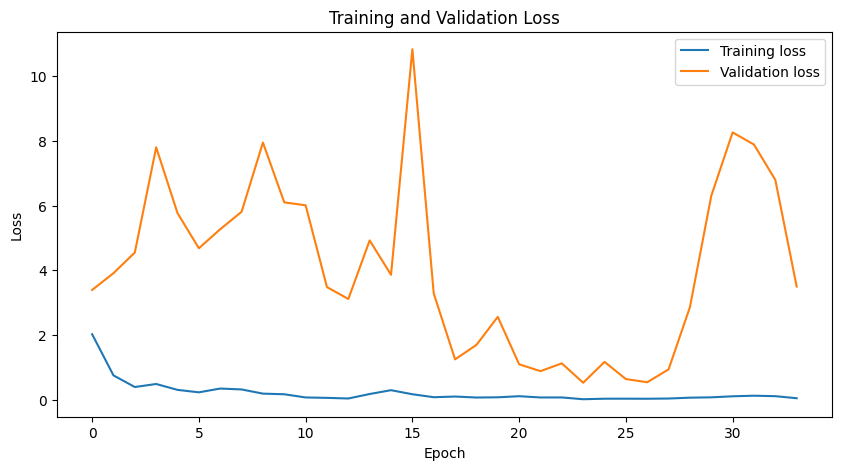

In [116]:
# Draw the training curve

import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(10,5))
plt.plot(history_model.history['loss'], label='Training loss')
plt.plot(history_model.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [117]:
import numpy as np

best_epoch = np.argmin(history_model.history['val_loss']) + 1  # +1 because epochs start at 1
best_val_loss = np.min(history_model.history['val_loss'])

print(f"Best epoch: {best_epoch}")
print(f"Lowest validation loss: {best_val_loss:.4f}")


Best epoch: 24
Lowest validation loss: 0.5204


In [118]:
test_loss, test_accuracy = ResNet50_keras_model.evaluate(X_test, Y_test)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9167 - loss: 0.3899
Test loss: 0.3899
Test accuracy: 0.9167



**What you should remember:**

- Very deep "plain" networks don't work in practice because they are hard to train due to vanishing gradients.  
- The skip-connections help to address the Vanishing Gradient problem. They also make it easy for a ResNet block to learn an identity function.
- There are two main type of blocks: The identity block and the convolutional block.
- Very deep Residual Networks are built by stacking these blocks together.

##  Congratulations

ResNet50 is a powerful model for image classification when it is trained for an adequate number of iterations. We hope you can use what you've learnt and apply it to your own classification problem to perform state-of-the-art accuracy.

Congratulations on finishing this lab! You've now implemented a state-of-the-art image classification system!

## References

This notebook introduces the ResNet architecture originally proposed by **He et al. (2015)**.  
The implementation draws inspiration from official resources and community examples, including work by **François Chollet** and the **DeepLearning.AI** team.

**Primary Source**
- Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun.  
  *Deep Residual Learning for Image Recognition*, 2015.  
  <https://arxiv.org/abs/1512.03385>


